In [ ]:
!rm -rf ./ML4CV_XAI
!git clone https://github.com/liuktc/ML4CV_XAI.git
!pip install captum grad_cam Craft-xai torcheval
%load_ext autoreload

%autoreload 2

import sys
sys.path.append('/kaggle/working/ML4CV_XAI')

In [ ]:
%load_ext autoreload

%autoreload 2

from models import vgg11_Syntetic, vgg_preprocess
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
torch.manual_seed(123)
np.random.seed(123)

In [40]:
model = vgg11_Syntetic().to(device)
model.load_state_dict(torch.load("./VGG11_synthetic.pth", map_location=device))
preprocess = vgg_preprocess

In [41]:
from data import SynteticFigures
from torchvision.transforms import InterpolationMode

TEST_SIZE = 256
BATCH_SIZE = 1

background_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
])

mask_preprocess = transforms.Compose([
        transforms.Resize((224, 224), interpolation=InterpolationMode.NEAREST),
        # transforms.GaussianBlur(5),
        transforms.ToTensor(),  # Convert to Tensor
])

data_test = SynteticFigures(background_path="./data/Waldo",
                            num_images=TEST_SIZE,
                            split='test',
                            num_shapes_per_image=3,
                            image_transform=preprocess,
                            background_transform=background_transform,
                            mask_preprocess=mask_preprocess,
                            num_other_shapes=0)

test_dl = DataLoader(data_test, BATCH_SIZE, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 224, 224]) torch.Size([1])


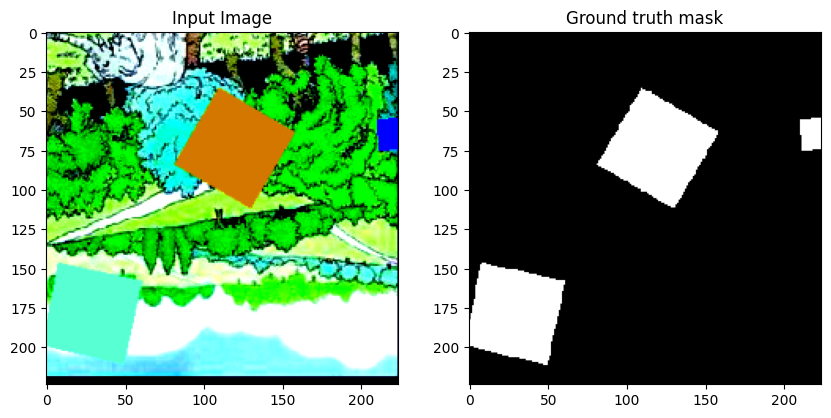

In [70]:
for images,mask, labels in test_dl:
    print(images.shape, labels.shape)
    plt.figure(figsize=(10,5))
    plt.tight_layout()
    plt.subplot(1,2,1)
    plt.title("Input Image")
    plt.imshow(images[0].permute(1,2,0))
    plt.subplot(1,2,2)
    plt.title("Ground truth mask")
    plt.imshow(mask[0].permute(1,2,0))

    plt.savefig("./plots/mask.pdf", bbox_inches='tight', dpi=600)
    break

In [63]:
# Percentage of attribution in the mask
def precision(attribution: torch.Tensor, ground_truth: torch.Tensor):
    # attribution.shape = (B, 1, H, W)
    # ground_truth.shape = (B, 1, H, W)

    attribution = attribution.reshape(-1)
    ground_truth = ground_truth.reshape(-1)

    attribution_masked = attribution[ground_truth == 1]
    return (attribution_masked.sum() / attribution.sum()).item()

def recall(attribution: torch.Tensor, ground_truth: torch.Tensor):
    # attribution.shape = (B, 1, H, W)
    # ground_truth.shape = (B, 1, H, W)

    attribution = attribution.reshape(-1)
    ground_truth = ground_truth.reshape(-1)

    attribution_masked = attribution[ground_truth == 1]
    return (attribution_masked.sum() / ground_truth.sum()).item()

Now we compare the ground truth attribution map (e.g. the binary mask) to the one created using various attribution methods.

torch.Size([1, 1, 7, 7])
torch.Size([1, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


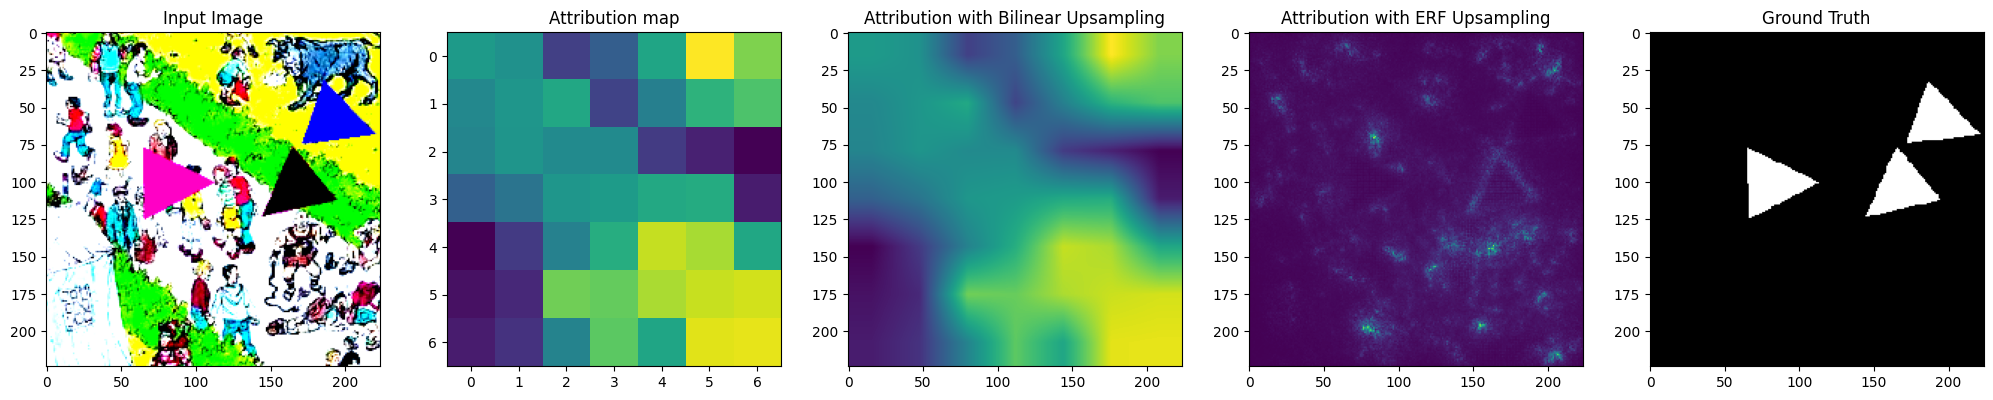

In [64]:
from utils import _GradCAMPlusPlus, SimpleUpsampling, ERFUpsampling

layer = model.features[-1]
attribute_method = _GradCAMPlusPlus(model, layer)
upsample1 = SimpleUpsampling((224,224))
upsample2 = ERFUpsampling(model,layer, device)
INDEX = 5
for i, (images, masks, labels) in enumerate(test_dl):
    if i < INDEX:
        continue
    labels = labels.to(device).reshape(-1)
    images = images.to(device)

    attributions = attribute_method.attribute(
        input_tensor=images,
        model=model,
        layer=layer,
        target=labels,
        baseline_dist=None,
    )
    print(attributions.shape)
    print(mask.shape)

    maps1 = upsample1(attributions, images)
    maps2 = upsample2(attributions, images)
    plt.figure(figsize=(25,5))
    plt.subplot(1,5,1)
    plt.title("Input Image")
    plt.imshow(images[0].permute(1,2,0))
    plt.subplot(1,5,2)
    plt.title("Attribution map")
    plt.imshow(attributions[0][0])

    plt.subplot(1,5,3)
    plt.title("Attribution with Bilinear Upsampling")
    # plt.show()
    plt.imshow(maps1[0][0])
    plt.subplot(1,5,4)
    plt.title("Attribution with ERF Upsampling")
    plt.imshow(maps2[0][0])
    plt.subplot(1,5,5)
    plt.title("Ground Truth")
    
    # plt.show()
    plt.imshow(masks[0].permute(1,2,0))

    plt.savefig(f"./plots/gradcam_{i}.pdf", format="pdf", dpi=600)
    plt.show()
    break



In [65]:
from results import ResultMetrics
results = ResultMetrics("./results.csv")

Results loaded from ./results.csv.


In [ ]:
from utils import _GradCAMPlusPlus,_DeepLiftShap, SimpleUpsampling, ERFUpsampling
from tqdm.auto import tqdm

for i in range(10, len(model.features)):
    layer = model.features[i]
    for attribute_method in [_GradCAMPlusPlus(model, layer), _DeepLiftShap()]:
        upsample1 = SimpleUpsampling((224,224))
        upsample2 = ERFUpsampling(model,layer, device)
        for i, (images, masks, labels) in tqdm(enumerate(test_dl)):
            labels = labels.to(device).reshape(-1)
            images = images.to(device)

            attributions = attribute_method.attribute(
                input_tensor=images,
                model=model,
                layer=layer,
                target=labels,
                baseline_dist=None,
            )
            masks = masks.sum(dim=1, keepdim=True)
            masks[masks > 0] = 1
            
            maps1 = upsample1(attributions, images)
            maps2 = upsample2(attributions, images)

            results.add_result("VGG11", 
                            attribute_method.__class__.__name__, 
                            f"features.{i}",
                            "precision",
                            upsample1.__class__.__name__, 
                            precision(maps1, masks))
            results.add_result("VGG11",
                                attribute_method.__class__.__name__,
                                f"features.{i}",
                                "recall",
                                upsample1.__class__.__name__,
                                recall(maps1, masks))

            results.add_result("VGG11",
                                attribute_method.__class__.__name__,
                                f"features.{i}",
                                "precision",
                                upsample2.__class__.__name__,
                                precision(maps2, masks))

            results.add_result("VGG11",
                                attribute_method.__class__.__name__,
                                f"features.{i}",
                                "recall",
                                upsample2.__class__.__name__,
                                recall(maps2, masks)) 

0it [00:00, ?it/s]

KeyboardInterrupt: 